### Load Libraries

In [1]:
import cuxfilter
import cudf
import cugraph
from pyproj import Proj, Transformer


def transform_coords(df, x='x', y='y'):
    # Apply transformation
    transform_4326_to_3857 = Transformer.from_crs('epsg:4326', 'epsg:3857')
    df[x], df[y] = transform_4326_to_3857.transform(
                                                df[x].to_array(), df[y].to_array()
                                            )
    return df

### Load data

In [9]:
data = cudf.read_csv('/home/ajay/data/data.csv')
data.head()

,trip_id,year,month,week,day,hour,usertype,gender,starttime,stoptime,...,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end
0,2355134,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:57:00,2014-07-01 00:07:00,...,131,Lincoln Ave & Belmont Ave,41.939365,-87.668385,15.0,303,Broadway & Cornelia Ave,41.945512,-87.645980,15.0
1,2355133,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:56:00,2014-07-01 00:00:00,...,282,Halsted St & Maxwell St,41.864580,-87.646930,15.0,22,May St & Taylor St,41.869482,-87.655486,15.0
2,2355130,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:33:00,2014-06-30 23:35:00,...,327,Sheffield Ave & Webster Ave,41.921687,-87.653714,19.0,225,Halsted St & Dickens Ave,41.919936,-87.648830,15.0
3,2355129,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:26:00,2014-07-01 00:24:00,...,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0,194,State St & Wacker Dr,41.887155,-87.627750,11.0
4,2355128,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:16:00,2014-06-30 23:26:00,...,320,Loomis St & Lexington St,41.872187,-87.661501,15.0,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0


## Converting the dataset to a graph (nodes, edges) format

### Extract Edges

In [3]:
edges = data[['from_station_id', 'to_station_id', 'gender', 'trip_id', 'year']]
edges.gender = edges.gender.astype('bool').astype('int')
edges.head()

,from_station_id,to_station_id,gender,trip_id,year
0,131,303,0,2355134,2014
1,282,22,0,2355133,2014
2,327,225,0,2355130,2014
3,134,194,0,2355129,2014
4,320,134,0,2355128,2014


### Get Stations as Nodes and add month, hour and year for trips as indices

In [4]:
_d1 = data.groupby(['from_station_id','month', 'hour', 'year']).count()['trip_id'].reset_index()
_d1.columns = ['vertex', 'month', 'hour','year', 'trip_started_count']

_d2 = data.groupby(['to_station_id','month', 'hour', 'year']).count()['trip_id'].reset_index()
_d2.columns =['vertex', 'month', 'hour','year', 'trip_ended_count']

_nodes = _d1.merge(_d2).drop_duplicates().reset_index(drop=True)

columns = ['vertex', 'name', 'x', 'y']

d1 = data[['from_station_id', 'from_station_name', 'latitude_start', 'longitude_start']].drop_duplicates().reset_index(drop=True)
d1 = d1.merge(data.groupby('from_station_id').count()['trip_id'].reset_index(), on='from_station_id')
d1.columns = columns + ['trips_started_count']

d2 = data[['to_station_id', 'to_station_name', 'latitude_end', 'longitude_end']].drop_duplicates().reset_index(drop=True)
d2 = d2.merge(data.groupby('to_station_id').count()['trip_id'].reset_index(), on='to_station_id')
d2.columns = columns + ['trips_ended_count']

nodes = d1.merge(d2).drop_duplicates('name').reset_index(drop=True)
nodes['total_trip_count'] = nodes.trips_started_count + nodes.trips_ended_count

#get transformed coords that can be mapped with bokeh maptiles
nodes = transform_coords(nodes)

nodes_final = nodes.merge(_nodes, on='vertex')
nodes_final.index = nodes_final[['month', 'hour', 'year', 'vertex']]
del nodes, _nodes, _d1, _d2, d1, d2

## cuxfilter analysis

In [5]:
cux_df = cuxfilter.DataFrame.load_graph((nodes_final, edges))

In [6]:
charts = []
charts.append(cuxfilter.charts.graph(
                                edge_source='from_station_id', edge_target='to_station_id',node_aggregate_col='total_trip_count',
                                node_aggregate_fn='mean', node_pixel_shade_type='linear', node_point_size=35,
                                edge_render_type='direct',#other option available -> 'curved'
                                edge_transparency=0.5, tile_provider='CARTODBPOSITRON',
                              )
             )
charts.append(cuxfilter.charts.range_slider(x='trips_started_count', data_points=10))
charts.append(cuxfilter.charts.range_slider(x='trips_ended_count', data_points=10))
charts.append(cuxfilter.charts.multi_select('year'))

charts.append(cuxfilter.charts.bar('month'))
charts.append(cuxfilter.charts.bar('hour'))
charts.append(cuxfilter.charts.view_dataframe(['name', 'month', 'hour', 'trip_started_count','trip_ended_count']))

In [7]:
d = cux_df.dashboard(charts, layout=cuxfilter.layouts.feature_and_triple_base)

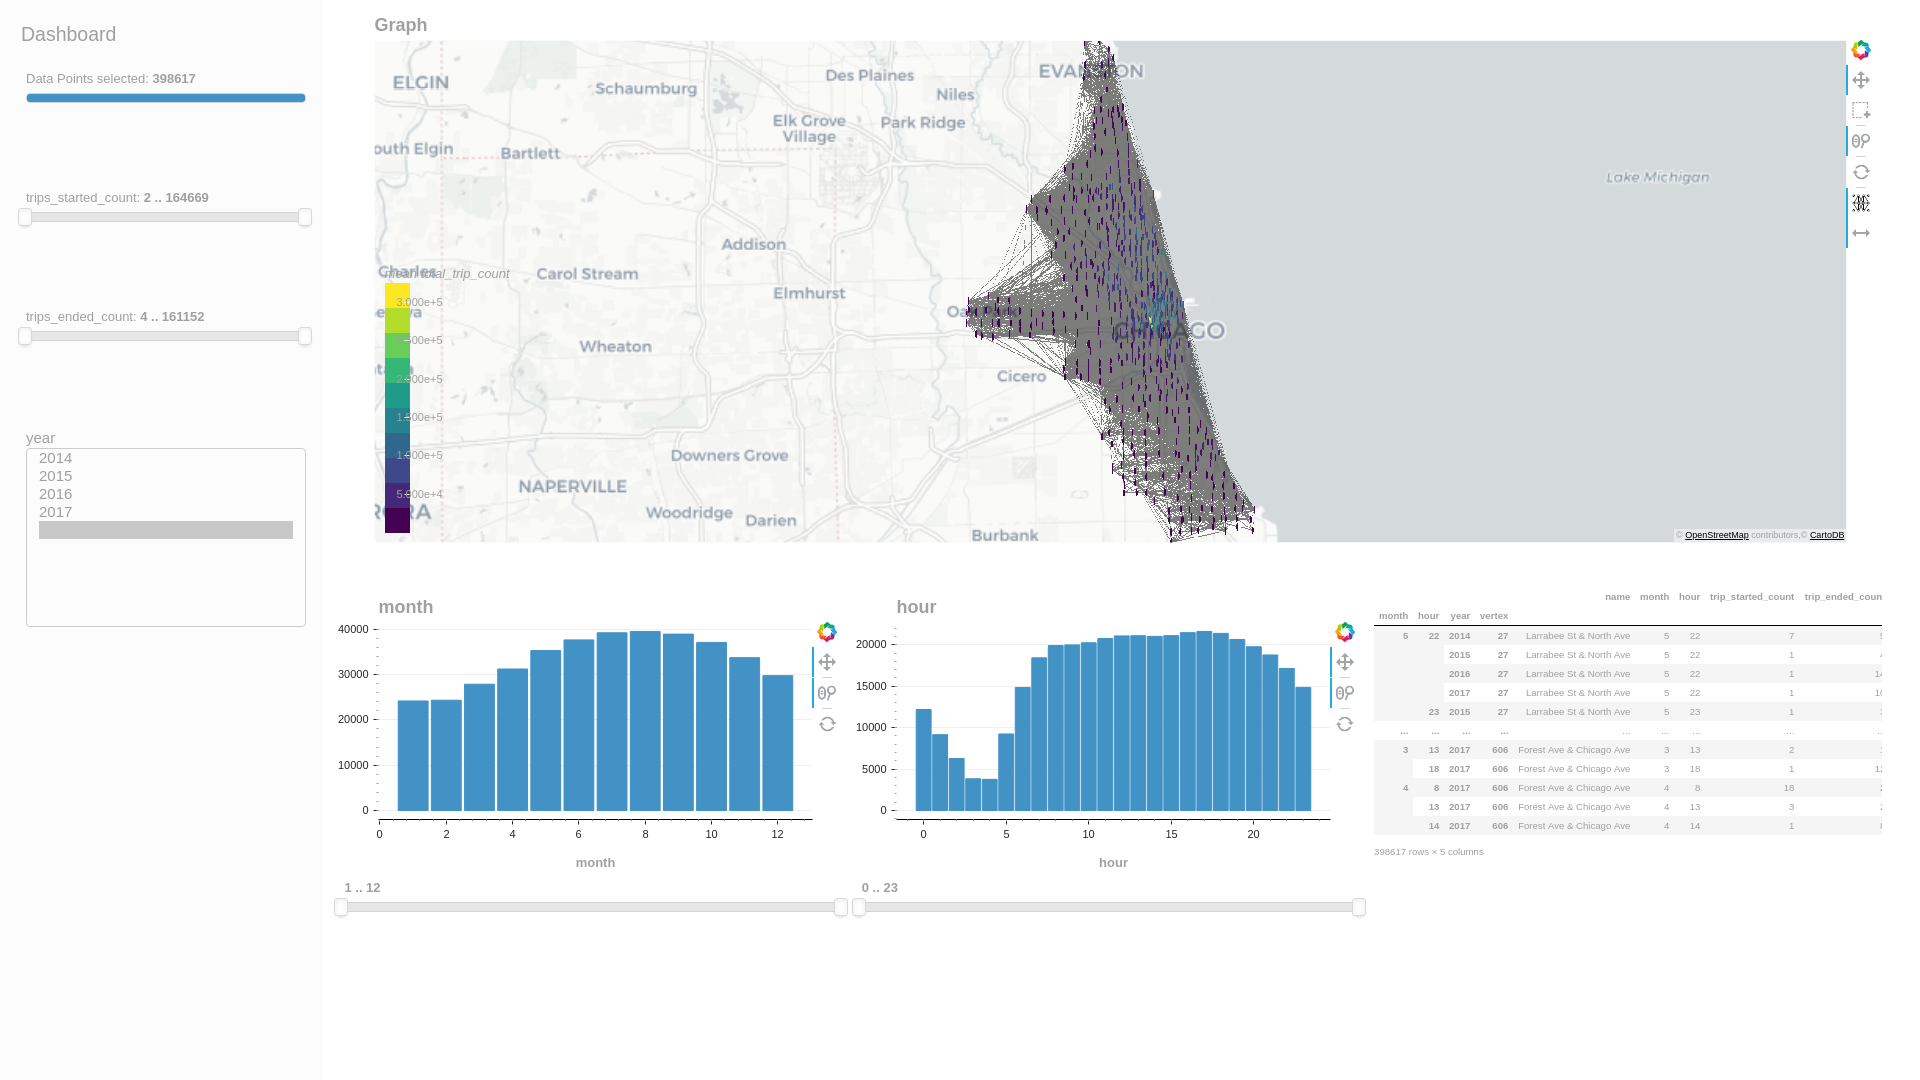

In [10]:
await d.preview()

In [8]:
# d.show()